### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://blog.openai.com/evolution-strategies/) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



In [1]:
import joblib
from six import BytesIO
def dumps(data):
    """converts whatever to string"""
    s = BytesIO()
    joblib.dump(data,s)
    return s.getvalue()
        
def loads(self,string):
    """converts string to whatever was dumps'ed in it"""
    return joblib.load(BytesIO(string))

### Tips on atari games
* There's all the pre-processing and tuning done for you in the code below
    * Images rescaled to 42x42 to speed up computation
    * We use last 4 frames as observations to account for ball velocity
    * The code below requires ```pip install Image``` and ```pip install gym[atari]``` 
    * You may also need some dependencies for gym[atari] - google "gym install all" dependencies or use our pre-built environment.
* The recommended agent architecture is a convolutional neural network. Dense network will also do.


May the force be with you!

In [2]:
from pong import make_pong
import numpy as np

env = make_pong()
n_actions = env.action_space.n
print(env.action_space)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Discrete(6)


In [3]:
#get the initial state
s = env.reset()
print (s.shape)

(4, 42, 42)


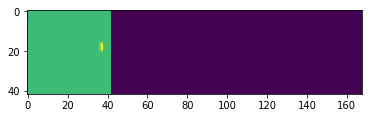

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 4 * 42 * 42
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

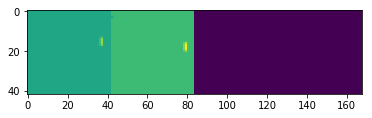

In [5]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T)

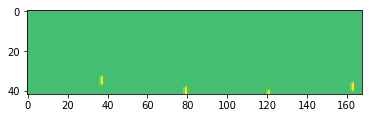

In [6]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T,vmin=0)

In [4]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(8,8),   # Weight matrix : (7056, 8) -> (8, 8) -> (8, 6)
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset().flatten()] * n_actions, range(n_actions));

/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [5]:
def generate_coefs():
    layer_1_coef = np.random.rand(7056, 8)
    layer_2_coef = np.random.rand(8, 8)
    layer_3_coef = np.random.rand(8, 6)
    
    return [layer_1_coef, layer_2_coef, layer_3_coef]

In [10]:
def generate_bias():
    layer_1_bias = np.random.rand(8)
    layer_2_bias = np.random.rand(8)
    layer_3_bias = np.random.rand(6)
    
    return [layer_1_bias, layer_2_bias, layer_3_bias]

In [10]:
coefs_generated = [generate_coefs() for _ in range(50)]
bias_generated = [generate_bias() for _ in range(50)]
index_solutions = 0

In [12]:
class MLPClassifierOverride(MLPClassifier):
    def _initialize(self, y, layer_units):
        # set all attributes, allocate weights etc for first call
        # Initialize parameters
        self.n_iter_ = 0
        self.t_ = 0
        self.n_outputs_ = y.shape[1]

        # Compute the number of layers
        self.n_layers_ = len(layer_units)

        # Output for regression
        #if not is_classifier(self):
        #    self.out_activation_ = 'identity'
        # Output for multi class
        if self._label_binarizer.y_type_ == 'multiclass':
            self.out_activation_ = 'softmax'
        # Output for binary class and multi-label
        else:
            self.out_activation_ = 'logistic'

        # Initialize coefficient and intercept layers
        self.coefs_ = coefs_generated[index_solutions]
        self.intercepts_ = bias_generated[index_solutions]

        for i in range(self.n_layers_ - 1):
            coef_init, intercept_init = self._init_coef(layer_units[i],
                                                        layer_units[i + 1])
            self.coefs_.append(coef_init)
            self.intercepts_.append(intercept_init)

        #if """self.solver in _STOCHASTIC_SOLVERS""" (True):
        self.loss_curve_ = []
        self._no_improvement_count = 0
        if self.early_stopping:
            self.validation_scores_ = []
            self.best_validation_score_ = -np.inf
        else:
            self.best_loss_ = np.inf

In [13]:
def play_game(t_max = 100):
    """
    plays a game and returns reward and parameters
    """
    s = [env.reset().flatten()]
    total_reward = 0
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba(s)[0] 
        
        a = np.random.choice(np.asarray(range(n_actions)), p=probs)#<sample action with such probabilities>
        
        new_s,r,done,info = env.step(a)
        new_s = [new_s.flatten()]
        #record sessions like you did before
        total_reward+=r
        
        s = new_s
        if done: break         
    return total_reward, agent.coefs_, agent.intercepts_

In [6]:
from IPython.display import clear_output

def select_best_n_solutions(samples_returned_number = 2, max_timesteps = 500):
    """ 100 timesteps ~= reward between -1.5 and 1.5)"""
    rewards_list = []
    bias_list = []
    coefs_list = []
    maximas_list = []
    returned_coefs = []
    returned_bias = []
    global index_solutions
    
    for i in bias_generated:
        agent = MLPClassifierOverride(hidden_layer_sizes=(8,8),   # Weight matrix : (7056, 8) -> (8, 8) -> (8, 6)
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
        
        print ("generating solution number " + str(index_solutions))
        agent.fit([env.reset().flatten()] * n_actions, range(n_actions));
        index_solutions += 1
        reward, coefs, bias = play_game(max_timesteps)
        clear_output()
        
        rewards_list.append(reward)
        coefs_list.append(coefs)
        bias_list.append(bias)
        print ("rewards list : " + str(rewards_list))
    
    for i in range(samples_returned_number):
        maximum_index = rewards_list.index(max(rewards_list)) # getting the index of the best parameters
        rewards_list.remove(max(rewards_list))                # removing the best parameter from the rewards_list
        maximas_list.append(maximum_index)                   # maximums_list contains the index of the maximas
    
    for i in maximas_list:
        returned_coefs.append(coefs_list[i])
        returned_bias.append(bias_list[i])
    
    print ("Maximum rewards'index : " + str(maximas_list))
    return returned_coefs, returned_bias

In [30]:
max_generation = 50
coefs_generated = [generate_coefs() for _ in range(max_generation)]
bias_generated = [generate_bias() for _ in range(max_generation)]
index_solutions = 0
best_coefs, best_bias = select_best_n_solutions(max_timesteps=100)

rewards list : [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, 0.0, -2.0, -2.0, -1.0, -2.0, -2.0, 1.0, -2.0, -2.0, -2.0, -1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.0, 1.0, -2.0, -2.0, -2.0, -1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0]
Maximum rewards'index : [18, 28]


In [7]:
from random import random

def crossover(coefs_computed, bias_computed):
    """
        returns one crossed parameter set out of lists of 2 coefs and bias sets
    """
    if (random() > 0.5):
        coefs_computed[0][0], coefs_computed[1][0] = coefs_computed[1][0], coefs_computed[0][0]
    if (random() > 0.5):
        coefs_computed[0][1], coefs_computed[1][1] = coefs_computed[1][1], coefs_computed[0][1]
    if (random() > 0.5):
        coefs_computed[0][2], coefs_computed[1][2] = coefs_computed[1][2], coefs_computed[0][2]
    if (random() > 0.5):
        bias_computed[0][0], bias_computed[1][0] = bias_computed[1][0], bias_computed[0][0]
    if (random() > 0.5):
        bias_computed[0][1], bias_computed[1][1] = bias_computed[1][1], bias_computed[0][1]
    if (random() > 0.5):
        bias_computed[0][2], bias_computed[1][2] = bias_computed[1][2], bias_computed[0][2]
    
    return coefs_computed[0], bias_computed[0]

In [8]:
def mutation(coef):
    
    """
    returns one mutated set of coefs out of one set of coefs
    """
    
    for j in range(7055):
        if (random() > 0.995):
            coef[0][j] = np.tanh(coef[0][j])
    for j in range(7):
        if (random() > 0.995):
            coef[1][j] = np.tanh(coef[1][j])
    for j in range(5):
        if (random() > 0.995):
            coef[2][j] = np.tanh(coef[2][j])
    return coef

In [97]:
coefs_crossed, bias_crossed = [], []

for _ in range(max_generation):
    tmp_coef, tmp_bia = crossover(best_coefs, best_bias)
    coefs_crossed.append(tmp_coef)
    bias_crossed.append(tmp_bia)

In [103]:
for i in range(max_generation):
    coefs_generated[i] = mutation(coefs_crossed[i])

In [ ]:
import copy

max_generation = 50
coefs_generated = [generate_coefs() for _ in range(max_generation)]
bias_generated = [generate_bias() for _ in range(max_generation)]
index_solutions = 0

for i in range(20):
    index_solutions = 0
    best_coefs, best_bias = select_best_n_solutions(max_timesteps=200)
    
    #generating a list of max_generation copies of the best samples:
    coefs_generated = []
    bias_generated = []
    
    for i in range(max_generation):
        coefs_generated.append(copy.copy(best_coefs[0]))
        bias_generated.append(copy.copy(best_bias[0]))
        
    #generating crossed sets 
    """
    for _ in range(max_generation):
        tmp_coef, tmp_bia = crossover(best_coefs, best_bias)
        coefs_crossed.append(tmp_coef)
        bias_crossed.append(tmp_bia)
    """ 
    #mutating set
   # for i in range(max_generation):
   #     print i
   #     coefs_generated[i] = mutation(coefs_generated[i])

rewards list : [-4.0, -4.0, -4.0, -2.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -1.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0]
generating solution number 40
